In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import os

# 하이퍼파라미터 설정
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 100
lrG = 0.0002  # Generator 학습률
lrD = 0.00005  # Discriminator 학습률 (더 낮게 설정)
beta1 = 0.5

# 데이터셋 로드
data_dir = "/workspace/daewoong/data_augmentation/data/anger_"
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = dsets.ImageFolder(root=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator 정의
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator 정의
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

# 손실 함수와 옵티마이저
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

# 레이블 정의
real_label = 0.9
fake_label = 0.0

# Gradient Penalty 함수
def gradient_penalty(real_data, fake_data, netD):
    alpha = torch.rand(real_data.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
    output = netD(interpolates)
    gradients = torch.autograd.grad(
        outputs=output, inputs=interpolates,
        grad_outputs=torch.ones_like(output),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# 학습 루프
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Discriminator 학습
        ############################
        netD.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)

        # 진짜 데이터 손실
        real_output = netD(real_images).view(-1)
        errD_real = criterion(real_output, torch.full((batch_size,), real_label, device=device))

        # 가짜 데이터 손실
        fake_output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(fake_output, torch.full((batch_size,), fake_label, device=device))

        # Gradient Penalty 추가
        gp = gradient_penalty(real_images, fake_images, netD)
        errD = errD_real + errD_fake + 10 * gp
        errD.backward()
        optimizerD.step()

        ############################
        # (2) Generator 학습
        ############################
        netG.zero_grad()
        # 가짜 이미지 생성 (새 그래프)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)

        # Generator가 Discriminator를 속이도록 학습
        labels = torch.full((batch_size,), real_label, device=device)
        output = netD(fake_images).view(-1)
        errG = criterion(output, labels)
        errG.backward()  # retain_graph=True 불필요
        optimizerG.step()

        # 학습 상태 출력
        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}")

    # 에포크마다 샘플 이미지 저장
    sample_dir = "/workspace/daewoong/data_augmentation/samples"
    os.makedirs(sample_dir, exist_ok=True)
    fake = netG(torch.randn(64, nz, 1, 1, device=device))
    vutils.save_image(fake.detach(), f"{sample_dir}/fake_epoch_{epoch}.png", normalize=True)

# 모델 저장
model_dir = "/workspace/daewoong/data_augmentation/model"
os.makedirs(model_dir, exist_ok=True)
torch.save(netG.state_dict(), f"{model_dir}/generator.pth")
torch.save(netD.state_dict(), f"{model_dir}/discriminator.pth")

[0/100][0/13] Loss_D: 11.3760 Loss_G: 1.0933
[1/100][0/13] Loss_D: 11.5630 Loss_G: 2.0627
[2/100][0/13] Loss_D: 11.1957 Loss_G: 2.9335
[3/100][0/13] Loss_D: 10.9665 Loss_G: 3.0689
[4/100][0/13] Loss_D: 11.0666 Loss_G: 3.2263
[5/100][0/13] Loss_D: 10.9118 Loss_G: 3.4403
[6/100][0/13] Loss_D: 10.9249 Loss_G: 3.4978
[7/100][0/13] Loss_D: 10.8943 Loss_G: 3.3988
[8/100][0/13] Loss_D: 10.7803 Loss_G: 3.4261
[9/100][0/13] Loss_D: 10.6632 Loss_G: 3.3051
[10/100][0/13] Loss_D: 10.5676 Loss_G: 3.6834
[11/100][0/13] Loss_D: 10.5707 Loss_G: 3.5062
[12/100][0/13] Loss_D: 10.5232 Loss_G: 3.4531
[13/100][0/13] Loss_D: 10.4432 Loss_G: 3.4700
[14/100][0/13] Loss_D: 10.4233 Loss_G: 3.4640
[15/100][0/13] Loss_D: 10.3908 Loss_G: 3.6519
[16/100][0/13] Loss_D: 10.4457 Loss_G: 3.5680
[17/100][0/13] Loss_D: 10.4346 Loss_G: 3.4436
[18/100][0/13] Loss_D: 10.5126 Loss_G: 2.8171
[19/100][0/13] Loss_D: 10.5406 Loss_G: 3.3582
[20/100][0/13] Loss_D: 10.7140 Loss_G: 3.0946
[21/100][0/13] Loss_D: 10.4346 Loss_G: 3.652

In [ ]:
import torch
import torchvision.utils as vutils
import os

# 하이퍼파라미터 설정
nz = 100  # 잠재 공간 크기
num_samples = 64  # 생성할 이미지 수
image_size = 64  # 이미지 크기
output_dir = "/workspace/daewoong/data_augmentation/samples"  # 샘플 이미지를 저장할 디렉토리

# Generator 클래스 정의 (학습 시 정의한 것과 동일해야 함)
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# 모델 초기화 (Generator 파라미터: nz, ngf, nc)
nz = 100  # 잠재 공간 크기
ngf = 64  # Generator feature map 크기
nc = 3    # 이미지 채널 수 (RGB)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(nz, ngf, nc).to(device)

# 저장된 Generator 가중치 로드
model_path = "/workspace/daewoong/data_augmentation/model/generator.pth"  # 학습된 모델 경로
netG.load_state_dict(torch.load(model_path, map_location=device))
netG.eval()  # 평가 모드로 설정

# 랜덤 노이즈 생성
noise = torch.randn(num_samples, nz, 1, 1, device=device)

# 샘플 이미지 생성
with torch.no_grad():  # 그래프 계산 비활성화
    fake_images = netG(noise)

# 결과 저장 디렉토리 생성
os.makedirs(output_dir, exist_ok=True)

# 샘플 이미지 저장
sample_path = os.path.join(output_dir, "sample_images.png")
vutils.save_image(fake_images, sample_path, normalize=True)
print(f"샘플 이미지를 {sample_path}에 저장했습니다.")

/tmp/ipykernel_76379/830452799.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(model_path, map_location=device))


RuntimeError: Error(s) in loading state_dict for Generator:
	size mismatch for main.0.weight: copying a param with shape torch.Size([100, 512, 4, 4]) from checkpoint, the shape in current model is torch.Size([10, 512, 4, 4]).

  1%|          | 11/1500 [00:00<00:14, 104.65it/s]

100%|██████████| 1500/1500 [00:10<00:00, 143.12it/s]


Loaded images shape: (1500, 128, 128, 3)


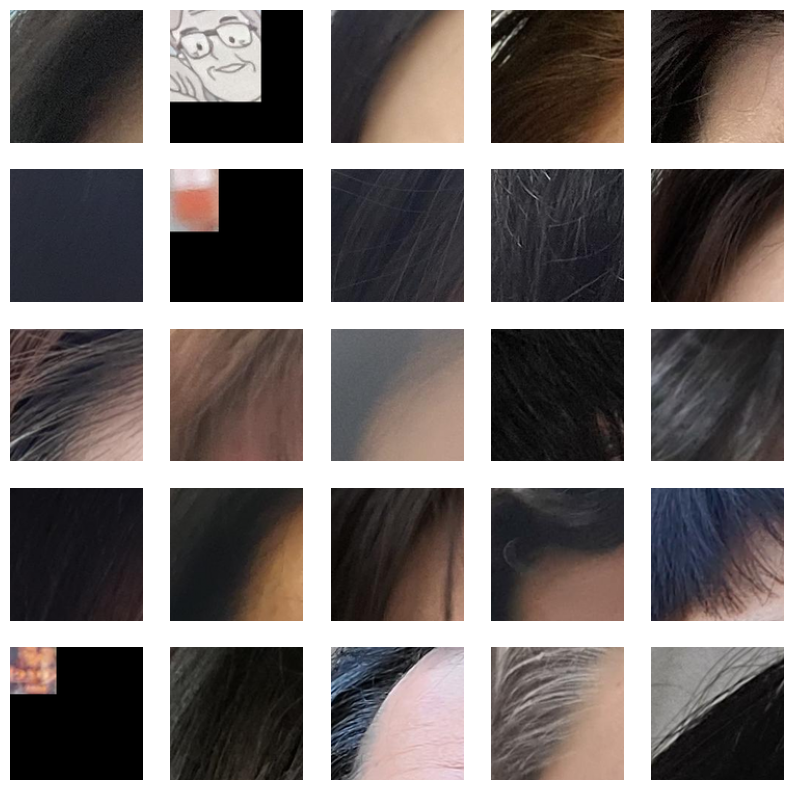

I0000 00:00:1734585622.046587  106950 service.cc:148] XLA service 0x7071300040a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734585622.046803  106950 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-12-19 05:20:22.117543: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1734585622.157906  106950 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1734585622.179447  106950 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/root/miniconda3/envs/daewoong/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/root/miniconda3/envs/daewoong/lib/python3.9/runpy.py", line 87, in _run_code

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/root/miniconda3/envs/daewoong/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/root/miniconda3/envs/daewoong/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/root/miniconda3/envs/daewoong/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_76379/792329260.py", line 117, in <module>

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 559, in predict

  File "/root/miniconda3/envs/daewoong/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 256, in one_step_on_data_distributed

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_1162]

In [27]:
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image as Img
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
import time
import imageio
import shutil

# 데이터 로드 및 이미지 리사이즈
PIC_DIR = '/workspace/daewoong/data_augmentation/data/anger_/anger/'
IMAGES_COUNT = 1500
ORIG_WIDTH = 178
ORIG_HEIGHT = 208
WIDTH = 128
HEIGHT = 128
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Img.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Img.Resampling.LANCZOS)
    images.append(np.uint8(pic))

images = np.array(images) / 255.0
print(f"Loaded images shape: {images.shape}")

# 첫 25개 이미지 표시
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# Generator 생성 함수
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    gen_input = Input(shape=(LATENT_DIM,))
    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    generator = Model(gen_input, x)
    return generator

# Discriminator 생성 함수
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    optimizer = RMSprop(learning_rate=0.0001, clipvalue=1.0, decay=1e-8)  # 수정된 부분
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy')
    return discriminator

# GAN 모델 생성
# Combine models into GAN
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

gan_input = Input(shape=(LATENT_DIM,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

# 수정된 RMSprop 설정
optimizer = RMSprop(learning_rate=0.0001, clipvalue=1.0)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

# 학습 파라미터
iters = 15000
batch_size = 16
RES_DIR = '/workspace/daewoong/data_augmentation/samples2'
if not os.path.exists(RES_DIR):
    os.makedirs(RES_DIR)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
d_losses = []
a_losses = []
start = 0

# GAN 학습 루프
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    if step % 50 == 49:
        gan.save_weights('/workspace/daewoong/data_augmentation/gan_weights.h5')
        print(f"Step {step + 1}/{iters}: d_loss={d_loss:.4f}, a_loss={a_loss:.4f} ({time.time() - start_time:.2f}s)")
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i]
        im = Img.fromarray((control_image * 255).astype(np.uint8))
        im.save(f"{RES_DIR}/generated_{step + 1}.png")

# 손실 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(a_losses, label='Adversarial Loss')
plt.legend()
plt.show()

# GIF 생성
images_to_gif = []
for filename in sorted(os.listdir(RES_DIR)):
    images_to_gif.append(imageio.imread(f"{RES_DIR}/{filename}"))
imageio.mimsave('/workspace/daewoong/data_augmentation/training_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)